In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


https://dacon.io/competitions/official/235492/codeshare/615?page=1&dtype=recent

colab 화면에서 F12를 누르고 하단의 콘솔창에 아래 코드 입력 후 실행

```
function ClickConnect(){
    console.log("코랩 연결 끊김 방지"); 
    document.querySelector("colab-toolbar-button#connect").click() 
}
setInterval(ClickConnect, 60 * 1000)

function CleanCurrentOutput(){ var btn = document.querySelector(".output-icon.clear_outputs_enabled.output-icon-selected[title$='현재 실행 중...'] iron-icon[command=clear-focused-or-selected-outputs]"); 
                              if(btn) { console.log("30분마다 출력 지우기"); btn.click(); } } setInterval(CleanCurrentOutput,1000*60*30);

```


# Tensorflow 버전 설정
SIA에서 제공하는 베이스라인 API는 Tensorflow==1.6 버전에 맞게 설정되어있습니다.

코랩을 사용하여 모델을 훈련시킬경우 Tensorflow==1.15.x 버전에서도 실행됨을 확인했으며 이를 위한 Tensorflow 버전을 설정합니다.

In [ ]:
%tensorflow_version 1.x

TensorFlow 1.x selected.


# 베이스라인 API 다운로드 후 작업 폴더로 이동


In [ ]:
!git clone https://github.com/SIAnalytics/simplified_rbox_cnn

Cloning into 'simplified_rbox_cnn'...
remote: Enumerating objects: 350, done.
remote: Total 350 (delta 0), reused 0 (delta 0), pack-reused 350
Receiving objects: 100% (350/350), 4.42 MiB | 13.20 MiB/s, done.
Resolving deltas: 100% (82/82), done.


In [ ]:
cd simplified_rbox_cnn

/content/simplified_rbox_cnn


# 사용할 config 파일 업로드

In [ ]:
!cp /content/drive/Shareddrives/SIA_API/num_config/* configs/

# 프로토콜 버퍼 컴파일
protos 폴더에 있는 프로토콜 버퍼 파일을 .py 형태로 컴파일해줍니다.

In [ ]:
!protoc protos/*.proto --python_out=.

# 설치 완료 테스트

In [ ]:
#!cp builders/model_builder_test.py .

In [ ]:
#!python model_builder_test.py

/usr/local/lib/python3.7/dist-packages/Cython/Compiler/Main.py:369: FutureWarning: Cython directive 'language_level' not set, using 2 for now (Py2). This will change in a later release! File: /content/simplified_rbox_cnn/utils/cintersection_rbox.pyx
  tree = Parsing.p_module(s, pxd, full_module_name)
The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

Running tests under Python 3.7.12: /usr/bin/python3
[ RUN      ] ModelBuilderTest.test_create_faster_rcnn_inception_resnet_v2_model_from_config
[       OK ] ModelBuilderTest.test_create_faster_rcnn_inception_resnet_v2_model_from_config
[ RUN      ] ModelBuilderTest.test_create_faster_rcnn_model_from_config_with_example_miner
[      

# 모델 훈련
train.py 모듈을 사용하여 모델을 훈련시킵니다. 모델을 훈련시키기전 rbox_cnn_resnet101.config 파일안 config값들의 경로가 위 경로에 맞게 설정이 되어야합니다.

또한 train.py를 실행시키기 위한 paser 값 중 save_interval_secs라는 파라미터가 있습니다.

이는 모델을 저장하는 시간을 설정하는 파라미터인데 기본설정은 1시간(3600초)으로 되어있습니다.

필요시 이 부분을 수정해주시면 되겠습니다.

faster_rcnn_resnet101_coco_11_06_2017 -> export-00

In [ ]:
!python train.py \
--pipeline_config_path="configs/05_rbox_cnn_resnet101.config" \
--train_dir="/content/drive/Shareddrives/SIA_API/train"

INFO:tensorflow:global step 59539: loss = 4.9907 (37.971 sec/step)
I1130 04:31:43.121788 140266458068864 learning.py:507] global step 59539: loss = 4.9907 (37.971 sec/step)
INFO:tensorflow:global step 59540: loss = 2.2729 (4.696 sec/step)
I1130 04:31:47.940476 140266458068864 learning.py:507] global step 59540: loss = 2.2729 (4.696 sec/step)
INFO:tensorflow:global step 59541: loss = 0.4548 (2.794 sec/step)
I1130 04:31:50.873290 140266458068864 learning.py:507] global step 59541: loss = 0.4548 (2.794 sec/step)
INFO:tensorflow:global step 59542: loss = 3.0809 (4.443 sec/step)
I1130 04:31:55.415402 140266458068864 learning.py:507] global step 59542: loss = 3.0809 (4.443 sec/step)
INFO:tensorflow:Recording summary at step 59542.
I1130 04:32:06.883854 140262188558080 supervisor.py:1050] Recording summary at step 59542.
INFO:tensorflow:global step 59543: loss = 4.2789 (12.589 sec/step)
I1130 04:32:08.094635 140266458068864 learning.py:507] global step 59543: loss = 4.2789 (12.589 sec/step)
I

# 모델 내보내기  
이제 모델이 준비되었으므로 나중에 사용할 수있는 형식으로 저장해야합니다. 

In [ ]:
import numpy as np
import re
import os

def check_last_model():
    lst = os.listdir("/content/drive/Shareddrives/SIA_API/train")
    lst = [l for l in lst if 'ckpt-' in l and '.index' not in l]
    steps=np.array([int(re.findall('\d+', l)[0]) for l in lst])
    last_model = lst[steps.argmax()]
    last_model_path = os.path.join('/content/drive/Shareddrives/SIA_API/train', last_model)
    print(last_model_path)

check_last_model()

/content/drive/Shareddrives/SIA_API/train/model.ckpt-59313.data-00000-of-00001


# 추론 시각화

In [ ]:
!python inference.py \
    --pipeline_config_path="configs/04_rbox_cnn_resnet101.config" \
    --ckpt_path="/content/drive/Shareddrives/SIA_API/train/model.ckpt-55775" \
    --image_dir='/content/drive/Shareddrives/SIA_API/data/test' \
    --dst_path='/content/drive/Shareddrives/SIA_API/csv/baseline_55775.csv'

/usr/local/lib/python3.7/dist-packages/Cython/Compiler/Main.py:369: FutureWarning: Cython directive 'language_level' not set, using 2 for now (Py2). This will change in a later release! File: /content/simplified_rbox_cnn/utils/cintersection_rbox.pyx
  tree = Parsing.p_module(s, pxd, full_module_name)
The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



Instructions for updating:
Use `tf.cast` instead.


Instructions for updating:
Please use `layer.__call__` method instead.

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Instructions for updating:
tf.py_func is deprecated in TF V2. Instead, there are two
    options available in V2.


시각화 함수 생성

csv 에서 데이터를 읽어와서 출력하는 함수

매개변수로 step 수를 추가함

In [ ]:
import pandas as pd

import cv2
import matplotlib.pyplot as plt
%matplotlib inline

def show_n_mask(file_name, ckpt_num, obj_type=None, gray_mode=True):
    test_path = '/content/drive/Shareddrives/SIA_API/csv/baseline_{}.csv'.format(ckpt_num)
    test = pd.read_csv(test_path)
    print('test dim : {}'.format(test.shape))

    imcoords_columns = ['point1_x', 'point1_y', 'point2_x', 'point2_y', 'point3_x', 'point3_y', 'point4_x', 'point4_y']
    STANDARD_COLORS = [
    'AliceBlue', 'Chartreuse', 'Aqua', 'Aquamarine', 'Azure', 'Beige', 'Bisque',
    'BlanchedAlmond', 'BlueViolet', 'BurlyWood', 'CadetBlue', 'AntiqueWhite',
    'Chocolate', 'Coral', 'CornflowerBlue', 'Cornsilk', 'Crimson', 'Cyan',
    'DarkCyan', 'DarkGoldenRod', 'DarkGrey'
    ]
    type_colors = dict(zip(list(range(1,22)), STANDARD_COLORS))

    fig= plt.figure(figsize=(18,18))
    # plot image
    img = cv2.imread('/content/drive/Shareddrives/SIA_API/data/test/images/'+file_name, cv2.COLOR_BGR2RGB)
    if gray_mode:
        plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2GRAY), cmap='gray')
    else:
        plt.imshow(img)
    
    # All object or selected objects(obj_type)
    for idx, row in test[test.file_name == file_name][['class_id']+imcoords_columns].iterrows():
        if (obj_type==row.class_id):
            coords = list(row[imcoords_columns].values) + list(row[imcoords_columns].values[:2])
            plt.fill(coords[::2],coords[1::2], facecolor=type_colors[row.class_id], edgecolor=type_colors[row.class_id], linewidth=2, alpha=0.5)
            # Label 'class_id' 1~16
            cx = row[imcoords_columns].values[::2].mean()
            cy = row[imcoords_columns].values[1::2].mean()
            plt.text(cx,cy, str(row.class_id), color='white', fontsize=12, fontweight='semibold')
        elif obj_type == None:
            coords = list(row[imcoords_columns].values) + list(row[imcoords_columns].values[:2])
            plt.fill(coords[::2],coords[1::2], facecolor=type_colors[row.class_id], edgecolor=type_colors[row.class_id], linewidth=2, alpha=0.5)
            # Label 'class_id' 1~16
            cx = row[imcoords_columns].values[::2].mean()
            cy = row[imcoords_columns].values[1::2].mean()
            plt.text(cx,cy, str(int(row.class_id)), color='white', fontsize=12, fontweight='semibold')
    plt.show()

test dim : (607, 11)


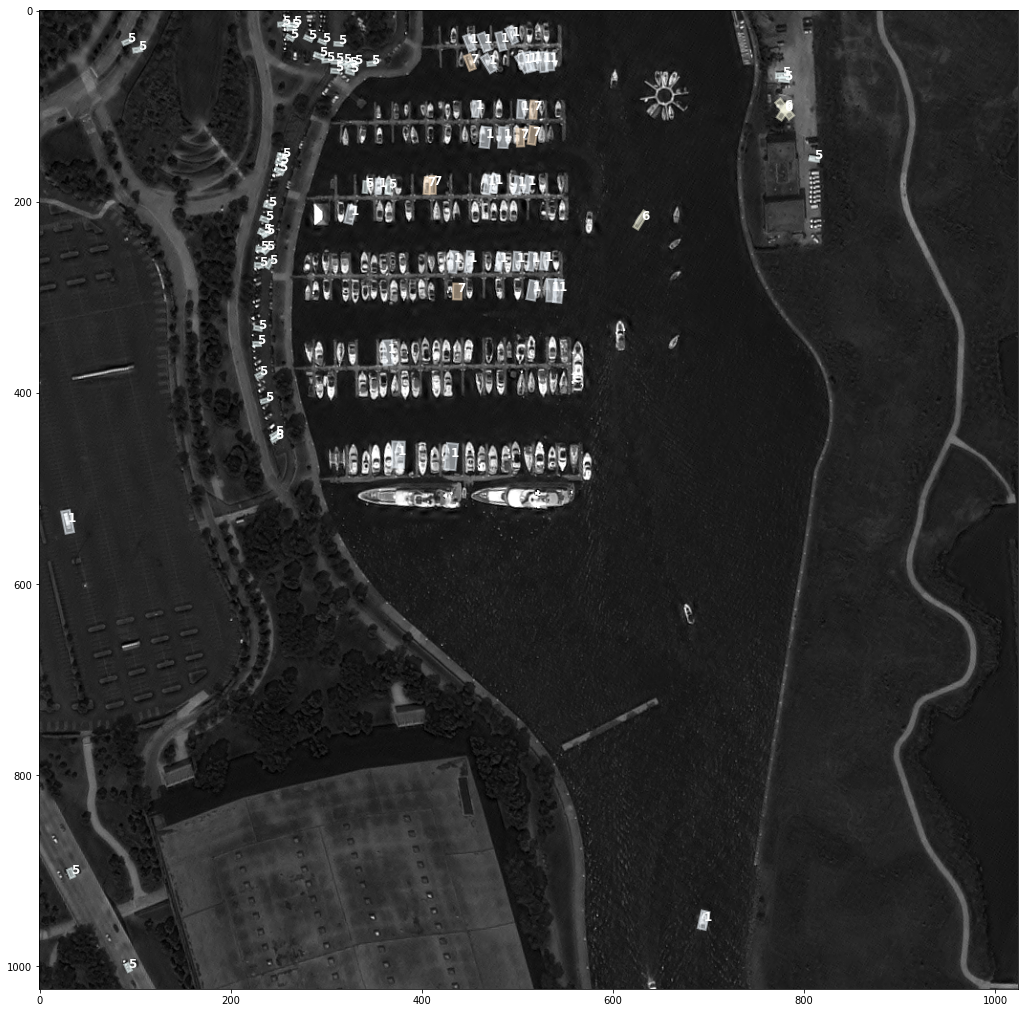

In [ ]:
show_n_mask('OBJ05716_PS3_K3A_NIA0363.png', 55775)

# 모델 재훈련
코랩 사용 한도인 12시간동안 모델을 학습시키면 약 30000번의 step이 학습이 됩니다. 이를 새로운 세션에서 학습하는 방법은

`rbox_cnn_resnet101.config` 파일안 `fine_tune_checkpoint`의 경로를 최초사용했던 `pretrained_model(faster_rcnn_resnet101_coco_11_06_2017)`이 아닌 우리가 학습시킨 모델로 사용하는 것입니디.

예를 들어 30000번 훈련된 모델을 얻게되면 `model.ckpt-30000` 라는 파일이 생성이 됩니다.

`rbox_cnn_resnet101.config` 파일안 `fine_tune_checkpoint`의 경로를 `model.ckpt-30000`의 경로로 변경하시면 모델의 훈련이 30001번부터 진행됨을 확인할 수 있습니다.

In [ ]:
!python train.py \
--pipeline_config_path="configs/05_rbox_cnn_resnet101.config" \
--train_dir="/content/drive/Shareddrives/SIA_API/train"

INFO:tensorflow:global step 59760: loss = 3.6043 (10.403 sec/step)
I1130 06:33:46.732401 140496801478528 learning.py:507] global step 59760: loss = 3.6043 (10.403 sec/step)
INFO:tensorflow:global step 59761: loss = 2.9216 (5.435 sec/step)
I1130 06:33:52.169694 140496801478528 learning.py:507] global step 59761: loss = 2.9216 (5.435 sec/step)
INFO:tensorflow:global step 59762: loss = 1.6401 (3.892 sec/step)
I1130 06:33:56.063742 140496801478528 learning.py:507] global step 59762: loss = 1.6401 (3.892 sec/step)
INFO:tensorflow:global step 59763: loss = 1.9230 (3.933 sec/step)
I1130 06:33:59.998516 140496801478528 learning.py:507] global step 59763: loss = 1.9230 (3.933 sec/step)
INFO:tensorflow:global step 59764: loss = 3.2002 (3.399 sec/step)
I1130 06:34:03.399111 140496801478528 learning.py:507] global step 59764: loss = 3.2002 (3.399 sec/step)
INFO:tensorflow:global step 59765: loss = 0.3792 (1.315 sec/step)
I1130 06:34:04.716432 140496801478528 learning.py:507] global step 59765: los

In [ ]:
check_last_model()

/content/drive/Shareddrives/SIA_API/train/model.ckpt-60000.data-00000-of-00001


In [ ]:
!python inference.py \
    --pipeline_config_path="configs/04_rbox_cnn_resnet101.config" \
    --ckpt_path="/content/drive/Shareddrives/SIA_API/train/model.ckpt-60000" \
    --image_dir='/content/drive/Shareddrives/SIA_API/data/test' \
    --dst_path='/content/drive/Shareddrives/SIA_API/csv/baseline_60000.csv'

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



Instructions for updating:
Use `tf.cast` instead.


Instructions for updating:
Please use `layer.__call__` method instead.

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Instructions for updating:
tf.py_func is deprecated in TF V2. Instead, there are two
    options available in V2.
    - tf.py_function takes a python function which manipulates tf eager
    tensors instead of numpy arrays. It's easy to convert a tf eager tensor to
    an ndarray (just call tensor.numpy()) but having access to eager tensors
    means `tf.py_function`s can use accelerators such as GPUs as well as
 

test dim : (705, 11)


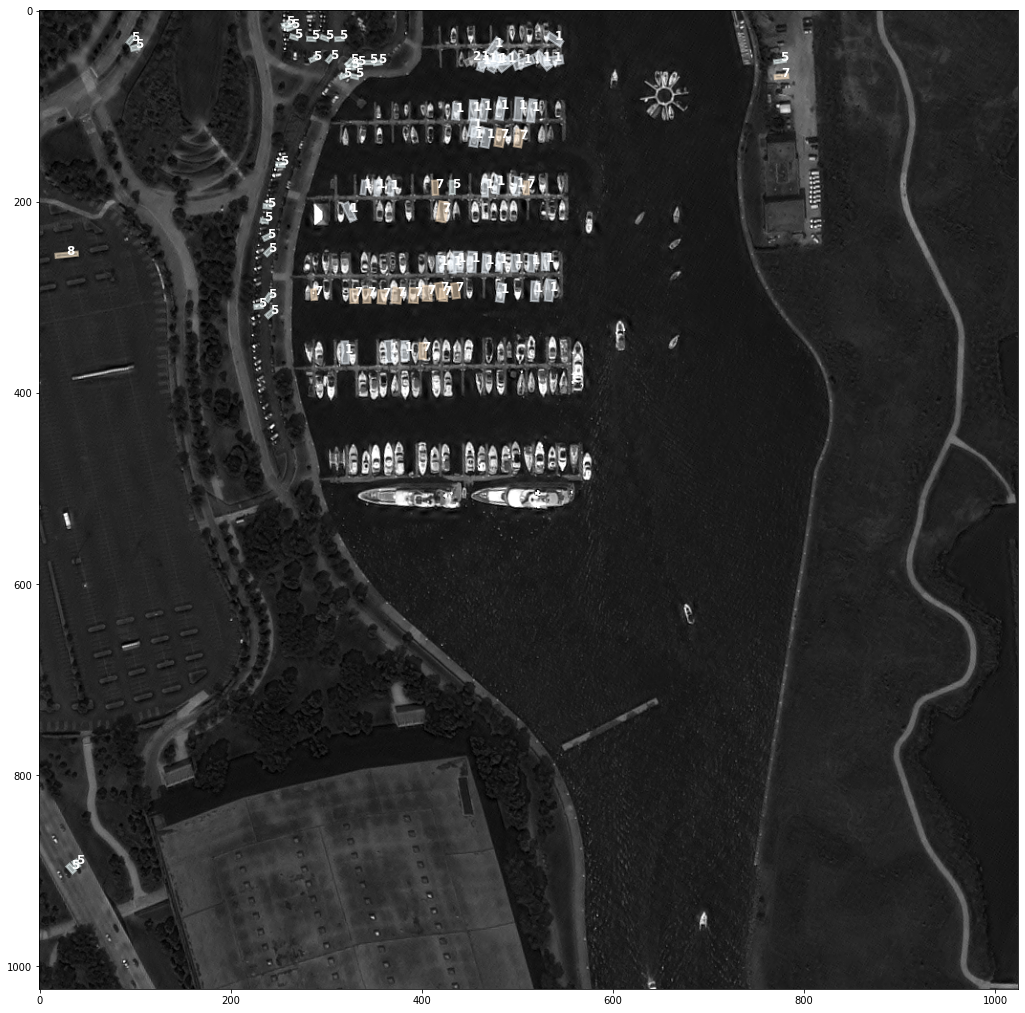

In [ ]:
show_n_mask('OBJ05716_PS3_K3A_NIA0363.png', 60000)

In [ ]:
!python export_inference_graph.py \
    --input_type image_tensor \
    --pipeline_config_path /content/drive/Shareddrives/SIA_API/num_config/05_rbox_cnn_resnet101.config \
    --trained_checkpoint_prefix /content/drive/Shareddrives/SIA_API/train/model.ckpt-60000 \
    --output_directory /content/drive/Shareddrives/SIA_API/export/export-06/

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



W1130 07:13:23.187734 139954932676480 module_wrapper.py:139] From export_inference_graph.py:101: The name tf.gfile.GFile is deprecated. Please use tf.io.gfile.GFile instead.

INFO:tensorflow:Scale of 0 disables regularizer.
I1130 07:13:23.201355 139954932676480 regularizers.py:98] Scale of 0 disables regularizer.
INFO:tensorflow:Scale of 0 disables regularizer.
I1130 07:13:23.201858 139954932676480 regularizers.py:98] Scale of 0 disables regularizer.

W1130 07:13:23.203183 139954932676480 module_wrapper.py:139] From /content/simplified_rbox_cnn/exporter.py:307: The name tf.gfile.MakeDirs is deprecated. Please use tf.io.gfile.m

In [ ]:
!python eval.py \
        --logtostderr \
        --checkpoint_dir=/content/drive/Shareddrives/SIA_API/train \
        --eval_dir=/content/drive/Shareddrives/SIA_API/eval_60000 \
        --pipeline_config_path=/content/simplified_rbox_cnn/configs/05_rbox_cnn_resnet101.config

I1130 18:54:20.082491 139967930767232 eval_util.py:292] Detection visualizations written to summary with tag image-29.
I1130 18:54:40.975672 139967930767232 eval_util.py:399] Running eval ops batch 100/200
I1130 18:55:08.514498 139967930767232 eval_util.py:399] Running eval ops batch 200/200
I1130 18:55:08.801352 139967930767232 eval_util.py:416] Running eval batches done.
I1130 18:55:08.801677 139967930767232 eval_util.py:124] Computing Pascal VOC metrics on results.
W1130 18:55:09.361952 139967930767232 object_detection_evaluation.py:226] The following classes have no ground truth examples: [ 0 12 15 17]
I1130 18:55:09.414963 139967930767232 eval_util.py:41] Writing metrics to tf summary.
I1130 18:55:09.416019 139967930767232 eval_util.py:48] PerformanceByCategory/mAP@0.5IOU/bridge: 0.000000
I1130 18:55:09.416179 139967930767232 eval_util.py:48] PerformanceByCategory/mAP@0.5IOU/bus: 0.006775
I1130 18:55:09.416288 139967930767232 eval_util.py:48] PerformanceByCategory/mAP@0.5IOU/civil

In [ ]:
%tensorflow_version 2.x

TensorFlow 2.x selected.


In [ ]:
import tensorboard

In [ ]:
!tensorboard dev upload --logdir eval


***** TensorBoard Uploader *****

This will upload your TensorBoard logs to https://tensorboard.dev/ from
the following directory:

eval

This TensorBoard will be visible to everyone. Do not upload sensitive
data.

Your use of this service is subject to Google's Terms of Service
<https://policies.google.com/terms> and Privacy Policy
<https://policies.google.com/privacy>, and TensorBoard.dev's Terms of Service
<https://tensorboard.dev/policy/terms/>.

This notice will not be shown again while you are logged into the uploader.
To log out, run `tensorboard dev auth revoke`.

Continue? (yes/NO) yes

Please visit this URL to authorize this application: https://accounts.google.com/o/oauth2/auth?response_type=code&client_id=373649185512-8v619h5kft38l4456nm2dj4ubeqsrvh6.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=openid+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fuserinfo.email&state=77OVgJe4qFsIcjjCtPABtNWVUhfHHR&prompt=consent&access_type=offline
Enter th